In [1]:
!pip install numpy torch torchvision matplotlib -q

In [9]:
import copy
from pathlib import Path

import matplotlib
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18

from cka import compute_cka
from viz import plot_cka_layer_trend, plot_cka_trend, save_figure

matplotlib.use('Agg')


In [3]:
SEED = 42
EPOCHS = 100
TRAIN_SAMPLES = 1024
CKA_SAMPLES = 512
BATCH_SIZE = 64
NUM_WORKERS = 2

CKA_LOADER_CONFIGS = {
    'train': {'train': True, 'seed': SEED + 1},
    'test': {'train': False, 'seed': SEED + 2},
}

RESNET18_LAYERS = [
    'conv1',
    'layer1.0.conv1',
    'layer2.0.conv1',
    'layer3.0.conv1',
    'layer4.0.conv1',
    'fc',
]

In [4]:
def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def build_resnet18_cifar(num_classes: int = 10) -> nn.Module:
    model = resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def get_cifar10_subset(train: bool, size: int, seed: int) -> Subset:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ])
    dataset = CIFAR10(root='./data', train=train, download=True, transform=transform)
    generator = torch.Generator().manual_seed(seed)
    indices = torch.randperm(len(dataset), generator=generator)[:size].tolist()
    return Subset(dataset, indices)


In [5]:
set_seed(SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Using device:', device)

output_dir = Path('plots')
output_dir.mkdir(parents=True, exist_ok=True)

print('Preparing CIFAR-10 subsets...')
train_subset = get_cifar10_subset(train=True, size=TRAIN_SAMPLES, seed=SEED)

cka_subsets = {
    name: get_cifar10_subset(
        train=config['train'],
        size=CKA_SAMPLES,
        seed=config['seed'],
    )
    for name, config in CKA_LOADER_CONFIGS.items()
}

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
cka_loaders = {
    name: DataLoader(
        subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    for name, subset in cka_subsets.items()
}
cka_loader_names = list(cka_loaders.keys())

model = build_resnet18_cifar()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

print('Capturing epoch-0 baseline...')
baseline_state = copy.deepcopy(model.state_dict())

epoch_states = [(0, baseline_state)]  # Store (epoch_num, state) tuples
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / max(1, len(train_loader))
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{EPOCHS} - loss: {avg_loss:.4f}')
        epoch_states.append((epoch, copy.deepcopy(model.state_dict())))

print('Computing CKA per epoch...')
baseline_model = build_resnet18_cifar()
baseline_model.load_state_dict(baseline_state)

diag_by_epoch = {name: [] for name in cka_loaders}
last_cka_matrices = {name: None for name in cka_loaders}

for epoch_num, state in epoch_states:
    epoch_model = build_resnet18_cifar()
    epoch_model.load_state_dict(state)

    for loader_name, cka_loader in cka_loaders.items():
        cka_matrix = compute_cka(
            baseline_model,
            epoch_model,
            cka_loader,
            layers=RESNET18_LAYERS,
            model2_layers=RESNET18_LAYERS,
            device=device,
            progress=False,
        )[0]
        last_cka_matrices[loader_name] = cka_matrix
        diag = torch.diag(cka_matrix).detach().cpu().numpy()
        diag_by_epoch[loader_name].append(diag)
        print(f'Epoch {epoch_num} ({loader_name}): mean diag CKA = {diag.mean():.4f}')

epochs = [epoch_num for epoch_num, _ in epoch_states]
layer_trends_by_loader = {
    name: np.stack(diags, axis=0).T for name, diags in diag_by_epoch.items()
}

Using device: cuda
Preparing CIFAR-10 subsets...
Capturing epoch-0 baseline...
Epoch 10/100 - loss: 0.8974
Epoch 20/100 - loss: 0.1519
Epoch 30/100 - loss: 0.0189
Epoch 40/100 - loss: 0.0004
Epoch 50/100 - loss: 0.0002
Epoch 60/100 - loss: 0.0001
Epoch 70/100 - loss: 0.0050
Epoch 80/100 - loss: 0.0001
Epoch 90/100 - loss: 0.0001
Epoch 100/100 - loss: 0.0000
Computing CKA per epoch...
Epoch 0 (train): mean diag CKA = 1.0000
Epoch 0 (test): mean diag CKA = 1.0000
Epoch 10 (train): mean diag CKA = 0.5378
Epoch 10 (test): mean diag CKA = 0.5380
Epoch 20 (train): mean diag CKA = 0.5717
Epoch 20 (test): mean diag CKA = 0.5594
Epoch 30 (train): mean diag CKA = 0.5410
Epoch 30 (test): mean diag CKA = 0.5370
Epoch 40 (train): mean diag CKA = 0.5493
Epoch 40 (test): mean diag CKA = 0.5446
Epoch 50 (train): mean diag CKA = 0.5395
Epoch 50 (test): mean diag CKA = 0.5319
Epoch 60 (train): mean diag CKA = 0.5413
Epoch 60 (test): mean diag CKA = 0.5333
Epoch 70 (train): mean diag CKA = 0.5257
Epoch 7

In [10]:
epoch_loader_name = 'test' if 'test' in layer_trends_by_loader else cka_loader_names[0]
layer_trends = layer_trends_by_loader[epoch_loader_name]

fig, ax = plot_cka_trend(
    layer_trends,
    x_values=epochs,
    labels=RESNET18_LAYERS,
    markers=['o'],
    xlabel='Epoch',
    ylabel='CKA Score',
    title='Pretrained vs. Fine-tuned Across Epochs (ResNet-18)',
    legend=True,
)
for line in ax.get_lines():
    line.set_markersize(3)
ax.set_xticks(list(range(0, EPOCHS + 1, 10)))
ax.set_xlim(0, EPOCHS)
save_figure(fig, str(output_dir / 'resnet18_cifar10_cka_epoch_trends.png'))

In [11]:
cka_matrices = [last_cka_matrices[name] for name in cka_loader_names]

fig, ax = plot_cka_layer_trend(
    cka_matrices,
    layers=RESNET18_LAYERS,
    labels=cka_loader_names,
    ylabel='CKA Score',
    title='Pretrained vs. Fine-tuned Across Layers (ResNet-18)',
    legend=True,
)
save_figure(fig, str(output_dir / 'resnet18_cifar10_cka_layer_trend_by_loader.png'))

print('Saved to:', output_dir)

Saved to: plots


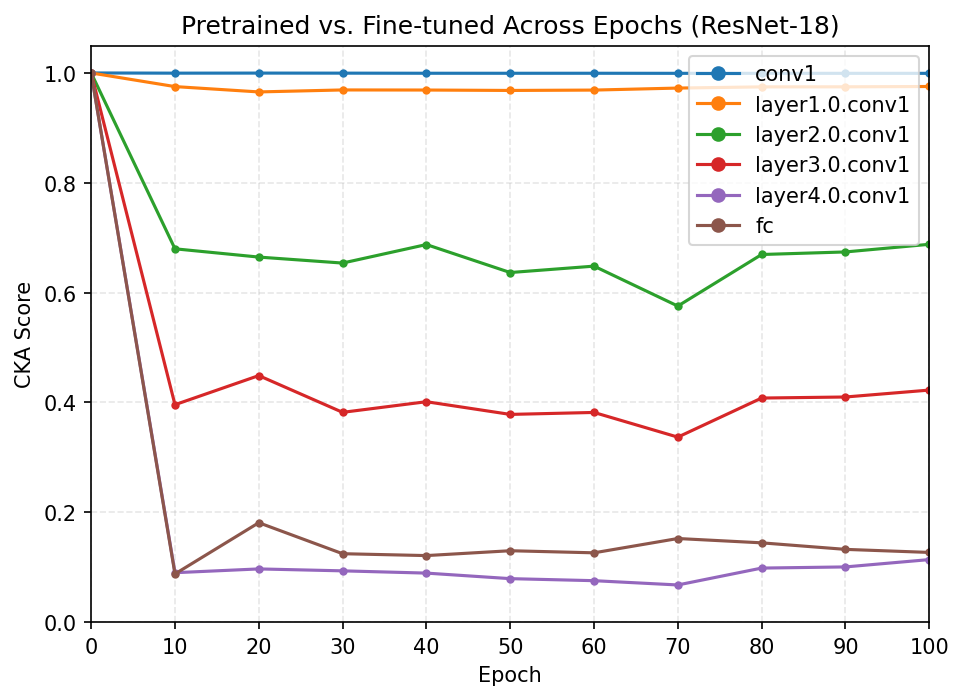

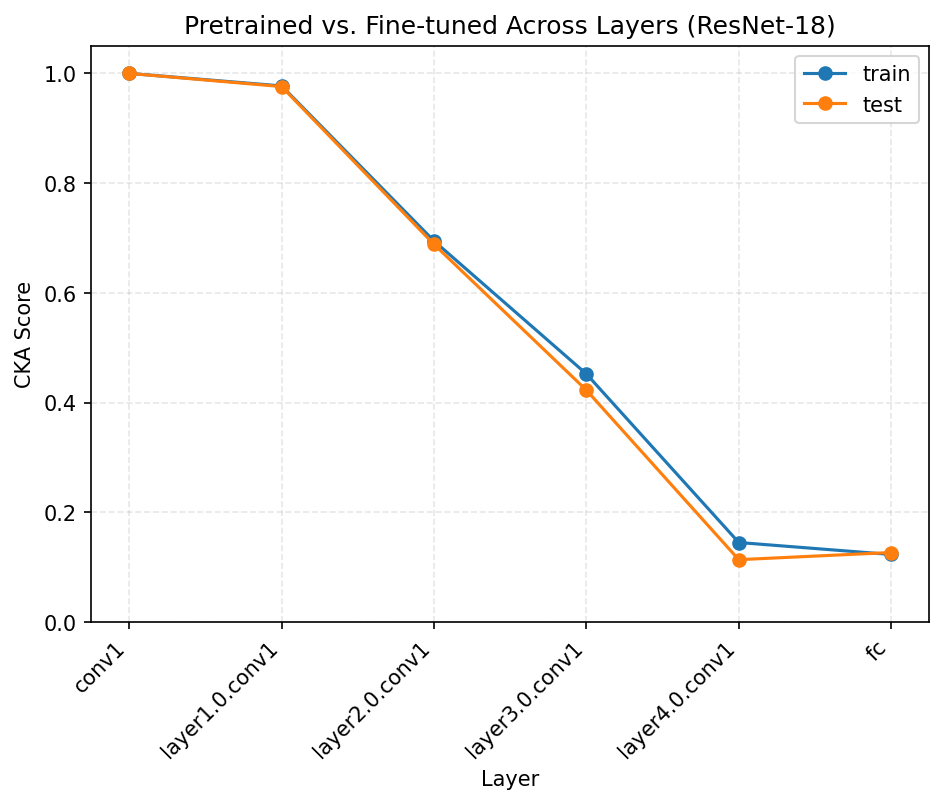

In [12]:
from IPython.display import Image, display

display(Image(filename=str(output_dir / 'resnet18_cifar10_cka_epoch_trends.png')))
display(Image(filename=str(output_dir / 'resnet18_cifar10_cka_layer_trend_by_loader.png')))